In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os

warnings.filterwarnings('ignore')

homedir = os.getenv("HOME")
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/2024-04-25-20240907T013110Z-001/2024-04-25/'

#VFS Catalog
#myTab=Table.read(catalog_path) # Read in VFS

#os.listdir(catalog_path)

In [2]:
%run ~/Downloads/readtablesv2.py --help

usage: readtablesv2.py [-h] [--tabledir TABLEDIR] [--tableprefix TABLEPREFIX]

Read in all virgo filament tables

options:
  -h, --help            show this help message and exit
  --tabledir TABLEDIR   directory where tables are stored
  --tableprefix TABLEPREFIX
                        prefix for tables; default is vf_v2


In [3]:
%run ~/Downloads/readtablesv2.py --tabledir $catalog_path

In [4]:
# Tables
myTab = v.main 
myTab2 = Table.read(catalog_path+'vf_v2_r_photometry.fits')

In [5]:
def Local_Density(cuttab):
    ra = np.array(cuttab['RA']) # Right ascension of each galaxy
    dec = np.array(cuttab['DEC']) # Declination of each galaxy
    vtarg = np.array(cuttab['vr'])

    points = []
    for i in range(len(dec)):
        points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)

    def distance(ra1, dec1, ra2, dec2):
        return ((ra1 - ra2) ** 2 + (dec1 - dec2) ** 2) ** ( 1 / 2) # Distance between two points    

    def Five_Nearest(points, target, K):
        pts = []
        n = len(points)
        d = []
 
        for i in range(n):
            if (abs(vtarg[i] - vtarg[i-1]) < 3300) & (abs(vtarg[i] - vtarg[i-1]) > 500): # Compares the velocity of each galaxy to the next and records it if it is within +/- 1500 km/s
                d.append({
                    "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                    "second": i # Stores new point that had its distance relative to the target found
                })
     
        d = sorted(d, key=lambda l:l["first"]) # Sorts d from smallest to largest distance for each target point
 
        for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
            pt = []
            pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
            pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
            pts.append(pt) # Stores all individual pt values as tuples
 
        return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)


    # Find five nearest galaxies to each galaxy
    five_nn = [] # Store nearest neighbors

    K = 6 # Number of times to calculate nearest neighbors
    for i in range(len(points)):
        target = points[i] # Switches target point
        for pt in Five_Nearest(points, target, K): # Calculates five nearest points for each points in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself        

    # Separating target points from fifth nearest points
    target_fnn = points # list of original target galaxies
    fifth_nearest_neighbors = five_nn[5::6] # fifth nearest point of each target


    # Finding angular distance
    dist_fifthnn = []

    # Calculates distance between each galaxy and its fifth nearest meighbor
    for i in range(len(fifth_nearest_neighbors)):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifthnn.append(distance(fifth_nearest_neighbors[i][0], fifth_nearest_neighbors[i][1], target0[0], target0[1])) # Produces distance array
 
    angle = np.array(dist_fifthnn)

    # Finds velocity of each of the five nearest neighbors
    #vtarg = myTab['vr'] # Recessional velocity from catalog (Target galaxy velocity)
    v = []
    for i in range(len(fifth_nearest_neighbors)):
        for j in range(len(points)): 
            if fifth_nearest_neighbors[i][0] == points[j][0]:
                v.append(cuttab['vr'][j])
    
    # Redshifts of fifth nearest neighbors
    # This compares each point in fifth nearest neighbors to each point in points and stores their respective z values
    c = 3*10**8 #m/s
    zc = (np.array(v)*1000)/c #cuttab['vr']
    z_fnn = []
    for i in range(len(fifth_nearest_neighbors)):
        for j in range(len(points)): 
            if fifth_nearest_neighbors[i][0] == points[j][0]:
                z_fnn.append(zc[j])
            
            
    # Converting angular distances to Mpc
    # Array of redshifts for each fifth nearest neighbor
    z = np.array(z_fnn)

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(angle)

    # Finding distance, in m, between the Sun and the galaxies
    H0 = 2.3*10**(-18) #/s
    c = 3*10**8 #m/s

    vz = z*c 
    d = vz/H0 #m

    # Using small angle approximation to convert to Mpc
    r_5 = ((d*np.tan(radians))*(3.24*10**(-23)))/0.74 #Mpc/h


    # Find fifth nearest neighbor density
    sigma_5 = 1/(r_5**2)
    
    return sigma_5

In [6]:
# Catalog cuts from Castignani

# RA cut
raTab = myTab['RA']
ramax = 280
ramin = 100
raflag = (raTab>ramin) & (raTab<ramax)

# DEC cut
decTab = myTab['DEC']
decmin = -1.3
decmax = 75
decflag = (decTab>decmin) & (decTab<decmax)

# Magnitude cut
Mr = myTab2['M_r']
Mrmin = -15.7
Mrflag = (Mr > Mrmin)

cut = raflag & decflag & Mrflag 

cuttab = myTab[cut]

In [7]:
print(len(cuttab))

3265


In [8]:
sigma_5 = Local_Density(cuttab)

In [9]:
# Reads in Environment table that contains local density values
envTab=Table.read(catalog_path+'vf_v2_environment.fits')

In [10]:
# Applying same cuts to environment table

# RA cut
raTab = myTab['RA']
ramax = 280
ramin = 100
raflag = (raTab>ramin) & (raTab<ramax)

# DEC cut
decTab = myTab['DEC']
decmin = -1.3
decmax = 75
decflag = (decTab>decmin) & (decTab<decmax)

# Magnitude cut
Mr = myTab2['M_r']
Mrmin = -15.7
Mrflag = (Mr > Mrmin)

cut2 = raflag & decflag & Mrflag

envcuttab = envTab[cut2]

In [11]:
my_sigma_5 = sigma_5
vfs_sigma_5 = envcuttab['n5th_2D'] # Local density from vfs

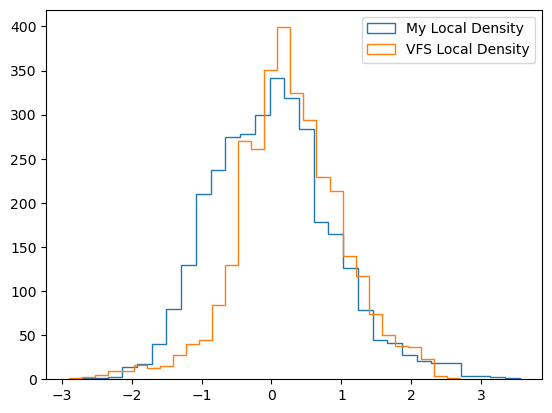

In [12]:
plt.hist(np.log10(my_sigma_5),label='My Local Density',histtype='step',bins=30)
plt.hist(np.log10(vfs_sigma_5),label='VFS Local Density',histtype='step',bins=30)

plt.legend()

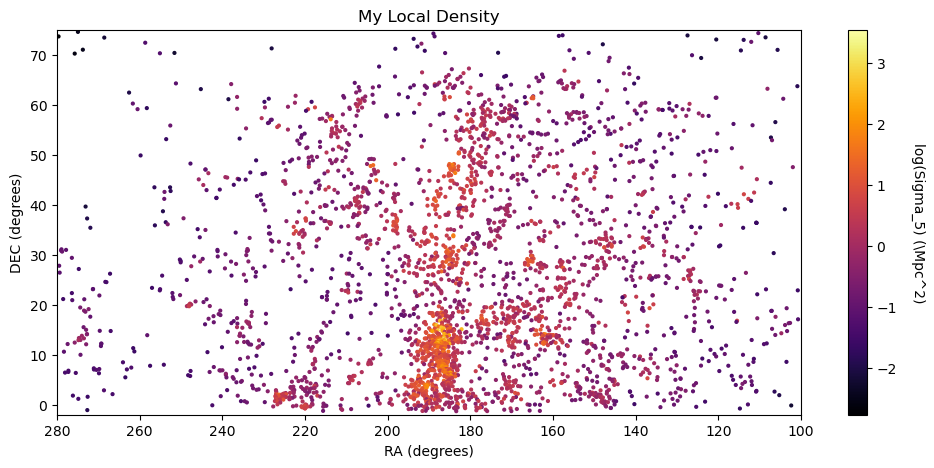

In [13]:
# My local density plot

ra = cuttab['RA']
dec = cuttab['DEC']
ccode = np.log10(my_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('My Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

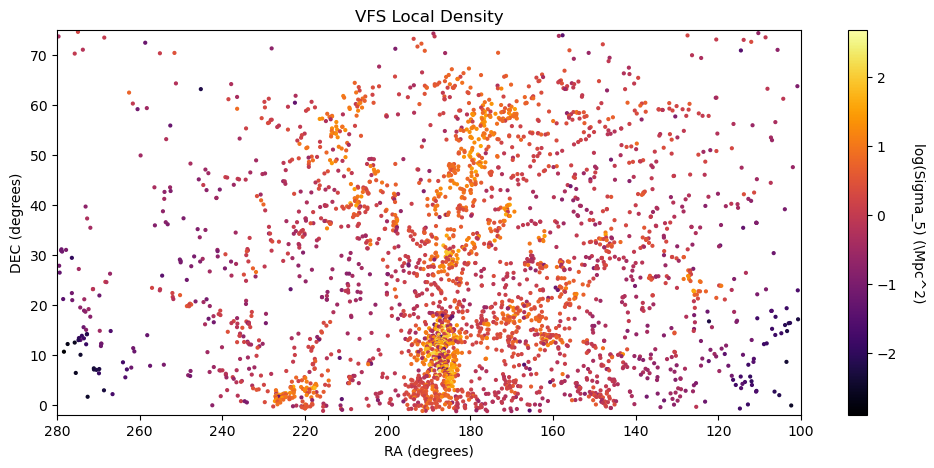

In [14]:
# VFS local density plot

ra = cuttab['RA']
dec = cuttab['DEC']
ccode = np.log10(vfs_sigma_5)

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('VFS Local Density')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(280,100)
plt.ylim(-2,75)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5) (\Mpc^2)',rotation=270,labelpad=20)

In [15]:
print(median(my_sigma_5))
print(median(vfs_sigma_5))

1.0283693551655928
1.6573257501512775


Text(0, 0.5, 'VFS Sigma_5 (log10)')

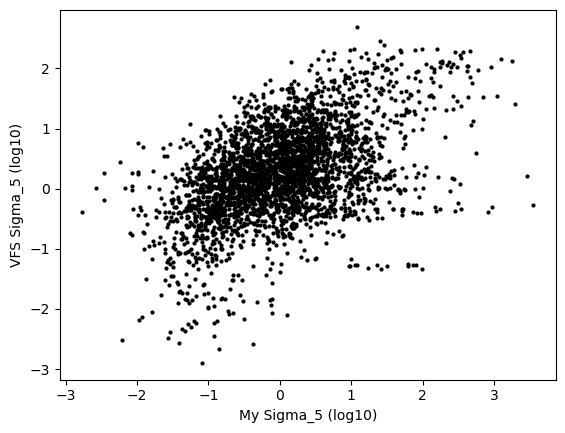

In [16]:
plt.scatter(np.log10(my_sigma_5),np.log10(vfs_sigma_5),s=4,color='black')
plt.xlabel('My Sigma_5 (log10)')
plt.ylabel('VFS Sigma_5 (log10)')